In [1]:
from matplotlib import pyplot as plt
from skimage.io import imread
from skimage.transform import resize
import os
import random
import numpy as np

In [2]:
!unzip yalefaces.zip

Archive:  yalefaces.zip
   creating: yalefaces/
   creating: yalefaces/person-4/
  inflating: yalefaces/person-4/rightlight  
  inflating: yalefaces/person-4/leftlight  
  inflating: yalefaces/person-4/normal  
  inflating: yalefaces/person-4/noglasses  
  inflating: yalefaces/person-4/happy  
  inflating: yalefaces/person-4/centerlight  
  inflating: yalefaces/person-4/sleepy  
  inflating: yalefaces/person-4/glasses  
  inflating: yalefaces/person-4/wink  
  inflating: yalefaces/person-4/surprised  
   creating: yalefaces/person-15/
  inflating: yalefaces/person-15/rightlight  
  inflating: yalefaces/person-15/leftlight  
  inflating: yalefaces/person-15/normal  
  inflating: yalefaces/person-15/noglasses  
  inflating: yalefaces/person-15/sad  
  inflating: yalefaces/person-15/centerlight  
  inflating: yalefaces/person-15/sleepy  
  inflating: yalefaces/person-15/glasses  
  inflating: yalefaces/person-15/wink  
  inflating: yalefaces/person-15/surprised  
   creating: yalefaces/pe

In [4]:
BASE_DIR = "yalefaces"
person_folders = [
  "person-1",
  "person-2",
  "person-3",
  "person-4",
  "person-5",
  "person-6",
  "person-7",
  "person-8",
  "person-9",
  "person-10",
  "person-11",
  "person-12",
  "person-13",
  "person-14",
  "person-15"
]

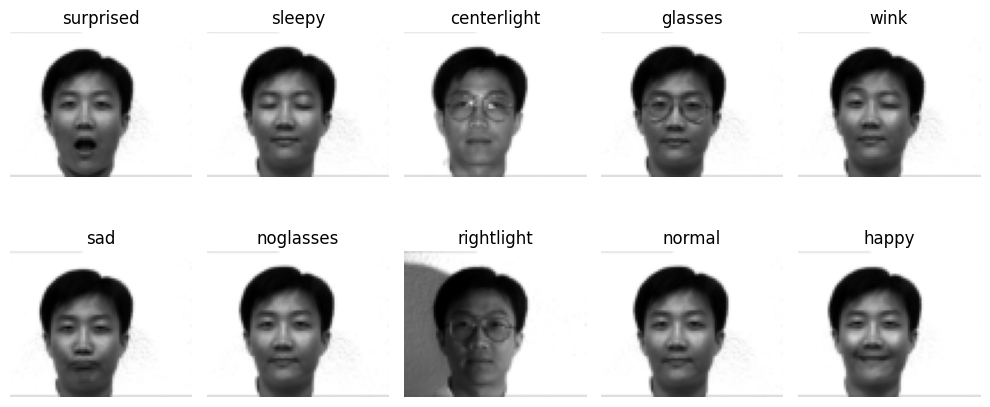

In [5]:
person_folder = random.choice(person_folders)
plt.figure(figsize=(10, 5)) # width, height in inches
for ith, filename in enumerate(os.listdir(os.path.join(BASE_DIR, person_folder))):
  image = imread(os.path.join(BASE_DIR, person_folder, filename))
  image = image.squeeze(0)
  image = resize(image, (64, 80), anti_aliasing=True)
  # display each image in a subplot
  plt.subplot(2, 5, ith + 1) #2 rows, 5 columns
  plt.imshow(image, cmap='gray')
  plt.axis('off') #hide axes
  plt.title(filename)

plt.tight_layout()
plt.show()

In [7]:
data = {}  # Initialize as a dictionary
for person_folder in person_folders:
  for filename in os.listdir(os.path.join(BASE_DIR, person_folder)):
    image = imread(os.path.join(BASE_DIR, person_folder, filename))
    image = resize(image, (1, 64, 80), preserve_range=True, mode='reflect')
    if person_folder not in data:
      data[person_folder] = [image]  # Fixed key format
    else:
      data[person_folder].append(image) # Consistent variable name
for person in data:
  data[person] = np.concat(data[person], axis=0).reshape(10, -1)

In [8]:
def standardizing(images: np.ndarray) -> np.ndarray:
  images = (images - images.mean()) / images.std()
  images = images.astype(np.float32)

  return images

In [12]:
class PrincipleComponentAnalysis:
  def __init__(self, d_principle: int = 1):
    self.d_principle = d_principle

  def fit(self, X: np.ndarray):
    cov = (X.T @ X)
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    # change the sign of the maximum absoluted value to positive
    max_abs_idx = np.argmax(np.abs(eigenvectors), axis = 0)
    signs = np.sign(eigenvectors[max_abs_idx, range(eigenvectors.shape[0])])
    eigenvectors = eigenvectors * signs[np.newaxis,:]
    eigenvectors = eigenvectors.T
    # rearrange the eigenvectors and eigenvalues
    eigen_pairs = [(np.abs(eigenvalues[i]), eigenvectors[i,:]) for i in range(eigenvectors.shape[0])]
    # Then, we sort the tuples from the highest to the lowest based on eigenvalues magnitude
    eigen_pairs.sort(key=lambda pair: pair[0], reverse = True)

    # converting to ndarray
    eigenvalues = np.array([value for (value, _) in eigen_pairs])
    eigenvectors = np.array([vector for (_, vector) in eigen_pairs])

    # select the principle components
    self.principle_values = eigenvalues[:self.d_principle]
    self._W = eigenvectors[:self.d_principle]

  def transform(self, X: np.ndarray) -> np.ndarray:
    X_hat = self._W @ X
    return X_hat

In [13]:
PCA = PrincipleComponentAnalysis(d_principle=20)

In [14]:
images = []
for person in data:
  images.append(data[person])

images = np.concat(images, axis=0)
images = standardizing(images)
images.shape

(150, 5120)

In [15]:
PCA.fit(images)

In [16]:
PCA._W.shape

(20, 5120)

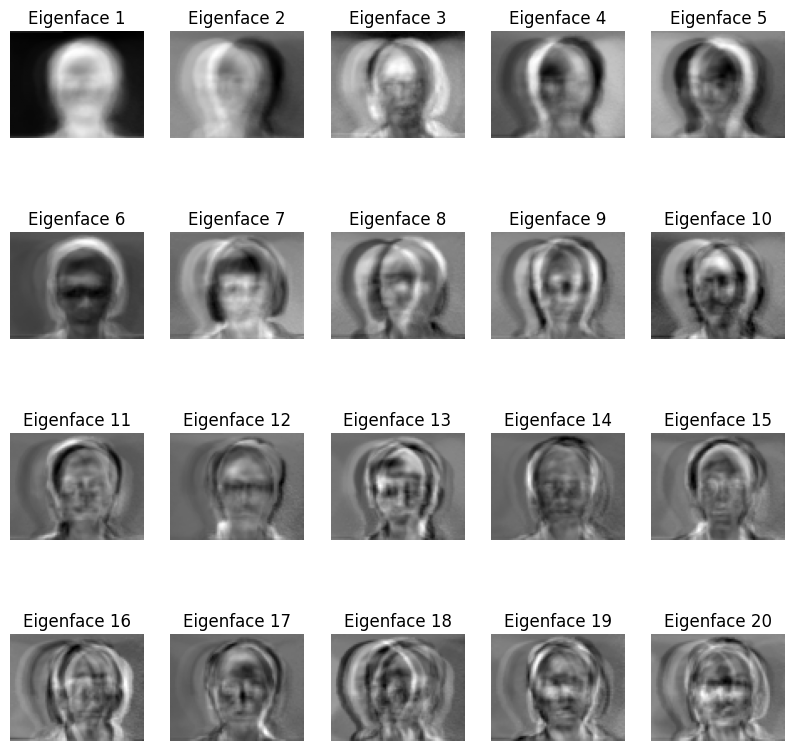

In [17]:
eigenfaces = PCA._W
eigenfaces = eigenfaces.reshape(20,64,80)
plt.figure(figsize=(10, 10))
for ith, eigenface in enumerate(eigenfaces):
  plt.subplot(4, 5, ith + 1)
  plt.imshow(eigenface, cmap='gray')
  plt.axis('off')
  plt.title(f'Eigenface {ith + 1}')

In [29]:
def Euclide_distance(X: np.ndarray, Y: np.ndarray):
  assert X.shape == Y.shape, f"{X.__str__()} and {Y.__str__()} must have the same shape"
  return (((X - Y)**2).sum())**0.5

In [23]:
TEST_DIR = "yalefaces/test"

In [24]:
test_images = []
labels = []
image_files = [f for f in os.listdir(TEST_DIR) if os.path.isfile(os.path.join(TEST_DIR, f))]

for filename in image_files:
    # Extract the label (person number) from the filename
    label = filename.split(".")[0]  # Extract the part before the first "."

    # Read and preprocess the image
    image_path = os.path.join(TEST_DIR, filename)
    image = imread(image_path)
    image = resize(image, (1, 64, 80), preserve_range=True, mode='reflect')

    # Append the image and label to the lists
    test_images.append(image)
    labels.append(label)


In [26]:
# Calculate mean faces for each person
mean_faces = {}
for person in data:
    mean_faces[person] = np.mean(data[person], axis=0)

# Project mean faces into PCA space
projected_mean_faces = {}
for person in mean_faces:
    projected_mean_faces[person] = PCA.transform(mean_faces[person])

In [35]:
predictions = {}  # Initialize predictions as a dictionary
for label, image in zip(labels, test_images):
  image = image.reshape(-1)
  projected_face = PCA.transform(image)
  closest_distance = np.inf
  closest_person = None
  for person in projected_mean_faces:
    mean_face = projected_mean_faces[person]
    distance = Euclide_distance(mean_face, projected_face)
    if distance < closest_distance:
      closest_distance = distance
      closest_person = person

  predictions[label] = closest_person # Now you can assign values

In [36]:
EMs = []
for label in predictions:
  EMs.append(label == predictions[label])

In [37]:
print(f"accuracy: {(np.mean(EMs)*100):0.2f}%")

accuracy: 66.67%
